In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, metrics
from scipy import optimize
import seaborn as sns

## Функции визуализации

In [16]:
def plot_line(ax, x_range, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """График разделяющей прямой с помощью вектора весов w и смещения x0"""
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    # рассчет прямой по уравенению x_1 = -(w_0 / w_1) * x_2 - b/w_1
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)
    
def plot_svm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            # расстояние от опорного объекта до гиперплоскости
            signed_dist = np.matmul(support, w)
            # наибольшее расстояние между опорными векторами
            margin = np.max(signed_dist) - np.min(signed_dist)
            # опорный вектор -1
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            # опорный вектор +1
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

### Генерация данных

In [3]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
n_features = 2
N = 100

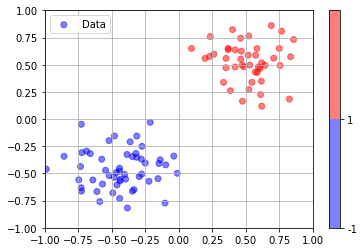

In [17]:
def generate_bipolar(n, mu=0.5, sigma=0.2):
    """ График двух гауссиан для линейного разделения"""
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    y = 2. * yB - 1
    X = X * y.reshape(-1, 1)
    X = X - X.mean(axis=0)
    return X, y

X, y = generate_bipolar(100)
plot_svm(X, y)

### Двойственная задача Лагранжа

In [18]:
def langrange(gramm_matrix, alpha):
    """двойственная функция"""
    return alpha.sum() - 0.5 * np.dot(alpha, np.dot(alpha, gramm_matrix))

def langrange_derive(gramm_matrix, alpha):
    """производная двойственной функции по alpha"""
    return np.ones(alpha.shape) - np.dot(alpha, gramm_matrix)

### Hard-margin SVM

$$\mathcal{L}_d = \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k $$

__C ограничением :__
- $\sum_{i=0}^n \alpha_i y_i = \langle \alpha, y \rangle = 0$
- $\alpha_i \ge 0, i\in 1..n$


$\langle y_i x_i, y_k  x_k \rangle$ - матрица Грамма

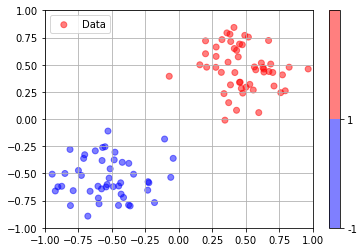

In [19]:
X, y = generate_bipolar(N, sigma=0.2)
plot_svm(X, y)

[3.17654939 3.27304407] -0.06348107420403726
Количество опорных векторов = 3


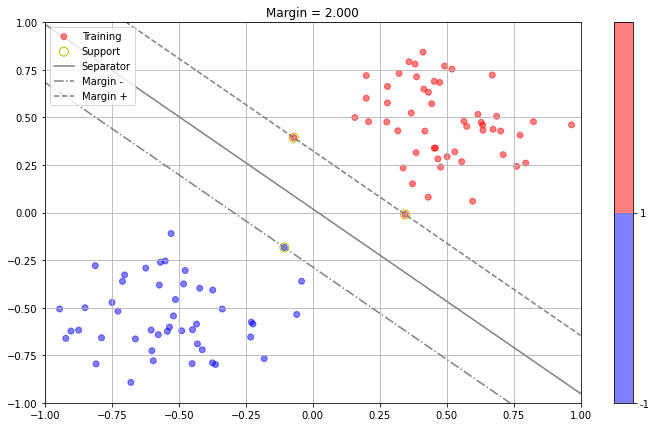

In [20]:
class HardMarginSVM:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.b = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        Xy = X * y.reshape(-1,1)
        
        # рассчет матрицы Грамма
        GramXy = np.matmul(Xy, Xy.T)
        
        #зададим ограничения для HardMarginSVM
        #(alpha, y) = 0
        first_constraint = {'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y}
        #alpha >= 0
        A = np.eye(N)
        second_constraint = {'type': 'ineq', 'fun': lambda a: np.dot(A, a), 'jac': lambda a: A}
        constraints = (first_constraint, second_constraint)

        # Для минимизации перейдем от вогнутой к выпуклой функции
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
        opt_res = optimize.minimize(fun=lambda a: -langrange(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -langrange_derive(GramXy, a), 
                                   constraints=constraints)
        #результат оптимизации - найденные параметры alpha
        self.alpha = opt_res.x
        #Рассчет параметров модели для отображения разделяющей поверхности w = alpha*x*y
        self.w = np.sum((self.alpha.reshape(-1,1) * Xy), axis=0) 
        
        epsilon = 1e-6
        # те объекты с alpha > eps - опорные
        self.supportVectors = X[self.alpha > epsilon]
        supportLabels = y[self.alpha > epsilon]
        # рассчет сдвига b
        self.b = supportLabels[0] - np.matmul(self.supportVectors[0].T, self.w)
    
    def predict(self, X):
        # предсказание модели
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * ((np.matmul(X, self.w) + self.b) > 0) - 1
    
hard_margin_svm = HardMarginSVM()
hard_margin_svm.fit(X, y)
print(hard_margin_svm.w, hard_margin_svm.b)

fig, ax = plt.subplots(1, figsize=(12, 7))
plot_svm(X, y, hard_margin_svm.supportVectors, hard_margin_svm.w, 
         hard_margin_svm.b, label='Training', ax=ax)

### Soft-margin SVM

$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \langle \alpha_i y_i x_i, \alpha_k y_k  x_k \rangle \\
\end{align}$$

__При ограничениях $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

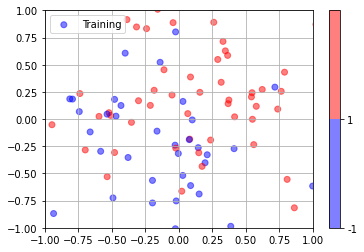

In [21]:
X, y = generate_bipolar(N, mu=0.2, sigma=0.5)
plot_svm(X, y, label='Training')

[1.30540614 1.3319167 ] 0.2772603971650525
Количество опорных векторов = 70


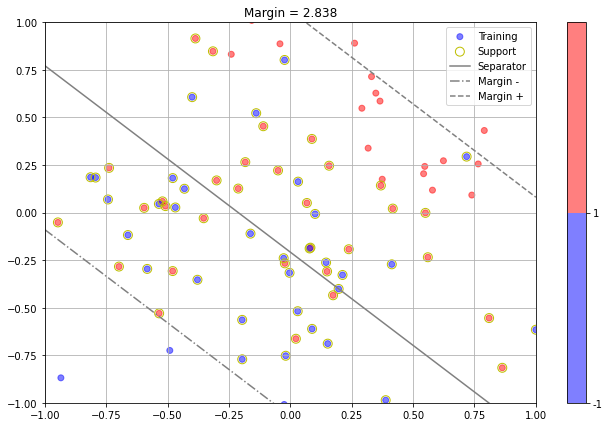

In [22]:
class SoftMarginSVM:
    
    def __init__(self, C):
        # Добавим параметр регуляризации/параметр влияния на ошибку
        self.C = C                                 
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    
    def fit(self, X, y):
        N = len(y)
        Xy = X * y.reshape(-1, 1)
        GramXy = np.matmul(Xy, Xy.T)

        # Определим условия задачи с оптимизацией
        # alpha * y = 0
        first_constraint = {'type': 'eq', 'fun': lambda a: np.dot(a, y), 'jac': lambda a: y}
        # -alpha <= 0 -> alpha >= 0 and alpha <= C
        A = np.vstack((-np.eye(N), np.eye(N)))
        # alpha >= 0 and alpha <= C
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        # A*alpha <= b <--> 0 < alpha <= C
        # -A -- производная выражения A*alpha <= b
        second_constraint = {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A}
        constraints = (first_constraint, second_constraint)

        opt_res = optimize.minimize(fun=lambda a: -langrange(GramXy, a),
                                    x0=np.ones(N),
                                    method='SLSQP',
                                    jac=lambda a: -langrange_derive(GramXy, a),
                                    constraints=constraints)

        self.alpha = opt_res.x
        self.w = np.sum((self.alpha.reshape(-1, 1) * Xy), axis=0)

        epsilon = 1e-6
        # Выберем опорные вектора (0 < alpha < C)
        valid_indices = (self.alpha > epsilon) & (self.alpha <= self.C)
        self.supportVectors = X[valid_indices]
        supportLabels = y[valid_indices]

        # Рассчитаем bias по средним bias для каждого опорного вектора
        if len(self.supportVectors) > 0:
            b_values = []
            for x_s, y_s in zip(self.supportVectors, supportLabels):
                b_values.append(y_s - np.dot(self.w, x_s))
            self.b = np.mean(b_values)
        else:
            print("No valid support vectors to compute bias.")
            self.b = 0 


    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        # по формуле 2(w^Tx + b) - 1 получаем значение объекта +1 или -1
        return 2 * (np.matmul(X, self.w) + self.b > 0) - 1
    
soft_margin_svm = SoftMarginSVM(C=1)
soft_margin_svm.fit(X, y)
print(soft_margin_svm.w, soft_margin_svm.b)

fig, ax = plt.subplots(1, figsize=(11, 7))
plot_svm(X, y, soft_margin_svm.supportVectors, soft_margin_svm.w, soft_margin_svm.b, label='Training', ax=ax)
plt.legend()

### Сравним результаты с sklearn реализацией

In [23]:
sklearn_svm = svm.SVC(kernel='linear', gamma='auto', C = 1)
sklearn_svm.fit(X, y)
sklearn_svm.coef_[0], sklearn_svm.intercept_[0]

(array([1.30542388, 1.33167589]), 0.283069119748921)

Количество опорных векторов = 70


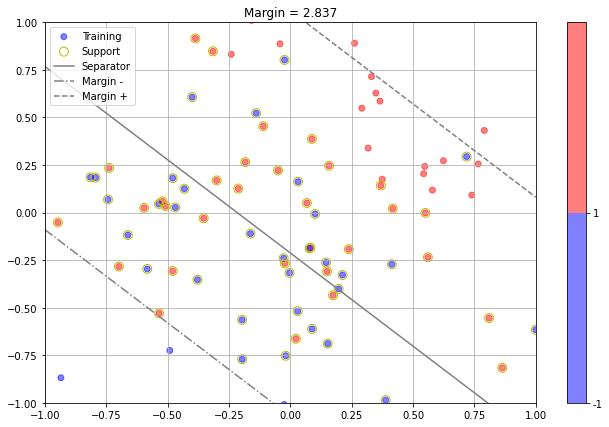

In [24]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plot_svm(X, y, sklearn_svm.support_vectors_, sklearn_svm.coef_[0], sklearn_svm.intercept_[0], 
        label='Training', ax=ax)

### Нелинейный SVM

Получить получить нелинейную матрицу Грамма можно так:

```python 
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T) 
```